<a href="https://colab.research.google.com/github/LapTQ/AI_Vacuum_Cleaner/blob/master/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies and import

In [1]:
!git clone https://github.com/hungpham13/Vietnamese-HTR.git

!pip install jiwer

Cloning into 'Vietnamese-HTR'...
remote: Enumerating objects: 2403, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2403 (delta 0), reused 4 (delta 0), pack-reused 2399
Receiving objects: 100% (2403/2403), 427.59 MiB | 26.24 MiB/s, done.
Checking out files: 100% (2395/2395), done.
     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149871 sha256=3a0d08542a753232e8d8312d43eefd8508352ad079ec5722d1e8e4e36b2459a2
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [2]:
import os
import re
import numpy as np
import tensorflow as tf
from jiwer import wer

import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path
import pickle

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Pepare dataset

In [3]:
!head -20 '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/0825_DataSamples 1/labels.json'

{
    "1.jpg": "Số 3 Nguyễn Ngọc Vũ, Hà Nội",
    "2.jpg": "Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội",
    "3.jpg": "58 Thái Thịnh, Đống Đa, Hà Nội",
    "4.jpeg": "Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa, Đồng Nai",
    "5.jpg": "Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương, phường Vĩnh Trung",
    "6.jpg": "Tòa nhà 34T, Hoàng Đạo Thúy, Hà Nội",
    "7.jpg": "40 Cát Linh, Đống Đa, Hà Nội",
    "8.jpg": "phòng 101, tầng 1, lô 04-TT5B, khu đô thị Tây Nam Linh Đàm",
    "9.JPG": "Nhà 87 ngõ 416 Đê La Thành",
    "10.JPG": "Up coworking Space, 89 Láng Hạ, Hà Nội",
    "11.jpg": "192 Ngô Đức Kế, quận 1, Hồ Chí Minh",
    "12.jpg": "số 5 Công Trường Mê Linh, phường Bến Nghé, quận 1",
    "13.jpg": "90A đường Mai Xuân Thưởng, tỉnh Gia Lai",
    "14.jpg": "96/7/12B Phạm Văn Đồng, thành phố Pleiku",
    "15.jpg": "168 Ngô Gia Tự, thành phố Hà Tĩnh"
}

In [4]:
train_img_dir = '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/0916_Data Samples 2'
test_img_dir = '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/1015_Private Test'

image_height, image_width = 120, 1900
vocab_size = 10000

# Fixed length allowed for any sequence
seq_length = 25

# Dimension for the image embeddings and token embeddings
embedding_dim = 512

# Per-layer units in the feed-forward network
units = 512

batch_size = 8

In [5]:
print('Number of training images:', len(list(Path(train_img_dir).glob('*.png'))))
print('Number of testing images:', len(list(Path(test_img_dir).glob('*.png'))))

Number of training images: 1823
Number of testing images: 549


In [6]:
import json

train_json = json.load(
    open(train_img_dir + '/labels.json', 'r')
)

test_json = json.load(
    open(test_img_dir + '/labels.json', 'r')
)

train_data = {os.path.join(train_img_dir, image_name): '<start> ' + label + ' <end>' for image_name, label in train_json.items()}
test_data = {os.path.join(test_img_dir, image_name): '<start> ' + label + ' <end>' for image_name, label in test_json.items()}

In [7]:
def decode_and_resize(img_path):
    img_string = tf.io.read_file(img_path)
    img = tf.image.decode_png(img_string)

    # resize to desired shape
    # input is of int [0, 255], but output is of float [0, 255]
    img = tf.image.resize_with_pad(img, image_height, image_width)

    # invert color      ##############################
    img = 255 - img

    # preprocess_input accept input of type float [0, 255]
    img = keras.applications.densenet.preprocess_input(img)

    return img

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace('<', '')
strip_chars = strip_chars.replace('>', '')
strip_chars = strip_chars.replace('/', '')
strip_chars = strip_chars.replace('-', '')

vectorization = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_length,
    standardize=lambda label: tf.strings.regex_replace(label, "[%s]" % re.escape(strip_chars), "")
)

vectorization.adapt(list(train_data.values()))

def preprocess_input(img_path, label):
    return decode_and_resize(img_path), vectorization(label)

def make_dataset(img_paths, labels, training):
    assert training is True or training is False

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    dataset = dataset.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=2000)
    # dataset = dataset.cache()
    if training: 
        dataset = dataset.shuffle(buffer_size=2000)
    dataset = dataset.batch(batch_size)

    return dataset


train_ds = make_dataset(
    train_data.keys(),
    train_data.values(),
    training = True
)
test_ds = make_dataset(
    test_data.keys(),
    test_data.values(),
    training = False
)

In [8]:
word_to_index = keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary())
index_to_word = keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary(),
    invert=True)

In [9]:
# for images, labels in train_ds.take(1):
#     for image, label in zip(images, labels):
#         plt.imshow(image)
#         plt.show()
#         print(label)

## Build model

In [10]:
base_cnn = keras.applications.DenseNet121(
            include_top=False,
            input_shape=(image_height, image_width, 3),
)

output = base_cnn.output
# squash the feature map from shape [batch_size, f_height, f_width, f_channel]
# to shape [batch_size, f_width, f_height x f_channel]
output = keras.layers.Permute((2, 1, 3))(output)
output = keras.layers.Reshape((output.shape[-3], -1))(output)
# shape after dense == (batch_size, f_width, embedding_dim)
output = keras.layers.Dense(embedding_dim)(output)
output = keras.layers.ReLU()(output)

encoder = keras.Model(base_cnn.input, output)


29097984/29084464 [==============================] - 0s 0us/step


In [11]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape = (batch_size, f_width, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, f_width, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, f_width, 1)
        # this gives an unnormalized score for each image feature
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, f_width, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context vector shape after sum = (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


Bahdanau vs Luong

In [12]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # print('RNN_Decoder: context_vector.shape == ', context_vector.shape)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [13]:
# encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vectorization.vocabulary_size())

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(trues, preds):
    loss_ = loss_object(trues, preds)
    
    mask = tf.cast(
        tf.math.logical_not(tf.math.equal(trues, 0)),
        dtype=loss_.dtype
    )

    loss_ *= mask

    return tf.reduce_mean(loss_)

In [15]:
!mkdir checkpoints
!mkdir checkpoints/train

In [16]:
checkpoint_path = 'checkpoints/train'
ckpt = tf.train.Checkpoint(
    encoder=encoder,
    decoder=decoder,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_path,
    max_to_keep=5
)
start_epoch = 0

In [17]:
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [18]:
loss_plot = []
wer_plot = []

In [19]:
@tf.function
def train_step(images, targets):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=targets.shape[0])

    dec_input = tf.expand_dims(
        [word_to_index('<start>')] * targets.shape[0],
        axis=1
    )

    with tf.GradientTape() as tape:
        features = encoder(images)

        for i in range(1, targets.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(targets[:, i], predictions)

            dec_input = tf.expand_dims(targets[:, i], 1)
    
    total_loss = loss / targets.shape[1]

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [20]:
def predict(images):
    # images shape == (batch_size, height, width, channels)

    # features shape == (batch_size, f_width, f_height x f_channels)
    features = encoder(images)

    hidden = decoder.reset_state(batch_size=images.shape[0])

    results = tf.expand_dims([word_to_index('<start>')] * images.shape[0], axis=1)

    for i in range(seq_length):
        predictions, hidden, attention_weights = decoder(
            results[..., -1:], #(4, 1)
            features,
            hidden
        )

        predicted_id = tf.expand_dims(
            tf.argmax(predictions, axis=-1),
            axis=-1
        )

        results = tf.concat([results, predicted_id], axis=-1) # tf.expand_dims(predicted_id, 0)
        
    return results

def evaluate(images, targets):
    # images shape == (batch_size, height, width, channels)
    results = predict(images)
    true_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:-1] if i.numpy() != 0 and i != word_to_index('<end>')])
        for j in targets]
    pred_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:] if i != word_to_index('<end>')])
        for j in results]
    
    return wer(true_texts, pred_texts)

## Train

In [ ]:
# tf.config.run_functions_eagerly(False)

Epoch: 1 Batch: 0 Loss: 4.2347
Epoch: 1 Batch: 50 Loss: 2.8449
Epoch: 1 Batch: 100 Loss: 3.3349
Epoch: 1 Batch: 150 Loss: 2.8848
Epoch: 1 Batch: 200 Loss: 3.2575
Epoch: 1 Loss: 3.088836
Time taken for 1 epoch 452.66 sec



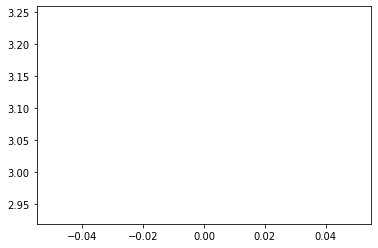

Epoch: 1 Batch: 0 WER: 1.00
Epoch: 1 Batch: 50 WER: 1.00
Epoch: 1 WER: 1.00


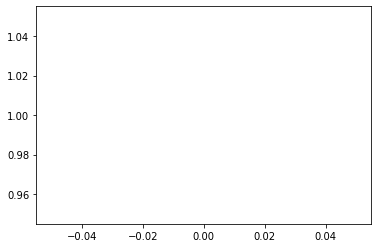

Epoch: 2 Batch: 0 Loss: 3.0235
Epoch: 2 Batch: 50 Loss: 2.8357
Epoch: 2 Batch: 100 Loss: 3.0677
Epoch: 2 Batch: 150 Loss: 2.9198
Epoch: 2 Batch: 200 Loss: 2.8065
Epoch: 2 Loss: 2.907040
Time taken for 1 epoch 348.04 sec



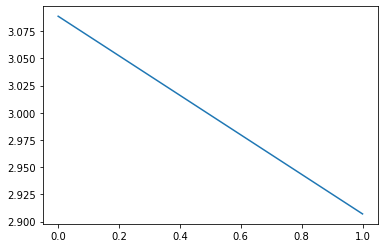

Epoch: 2 Batch: 0 WER: 0.94
Epoch: 2 Batch: 50 WER: 0.98
Epoch: 2 WER: 0.96


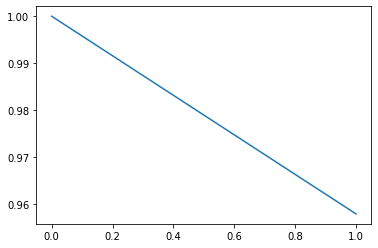

Epoch: 3 Batch: 0 Loss: 2.6907
Epoch: 3 Batch: 50 Loss: 2.5655
Epoch: 3 Batch: 100 Loss: 2.3986
Epoch: 3 Batch: 150 Loss: 2.3913
Epoch: 3 Batch: 200 Loss: 2.7235
Epoch: 3 Loss: 2.643261
Time taken for 1 epoch 347.51 sec



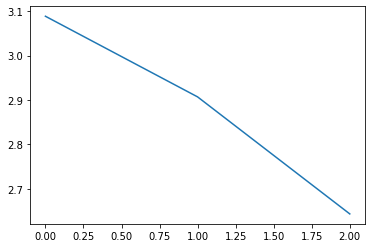

Epoch: 3 Batch: 0 WER: 1.81
Epoch: 3 Batch: 50 WER: 2.06
Epoch: 3 WER: 2.02


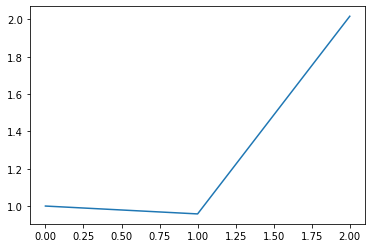

Epoch: 4 Batch: 0 Loss: 2.7003
Epoch: 4 Batch: 50 Loss: 2.5065
Epoch: 4 Batch: 100 Loss: 2.6639
Epoch: 4 Batch: 150 Loss: 2.1118
Epoch: 4 Batch: 200 Loss: 2.2758
Epoch: 4 Loss: 2.415181
Time taken for 1 epoch 346.92 sec



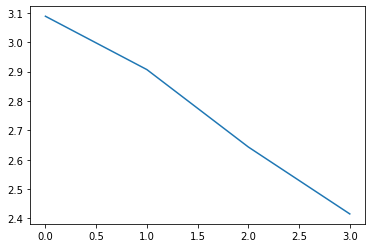

Epoch: 4 Batch: 0 WER: 1.81
Epoch: 4 Batch: 50 WER: 2.06
Epoch: 4 WER: 2.01


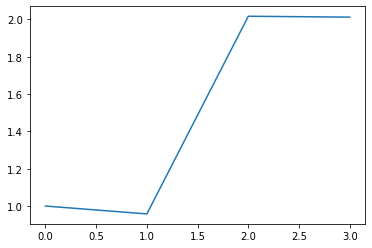

Epoch: 5 Batch: 0 Loss: 1.9643
Epoch: 5 Batch: 50 Loss: 2.2101
Epoch: 5 Batch: 100 Loss: 2.2602
Epoch: 5 Batch: 150 Loss: 2.4482
Epoch: 5 Batch: 200 Loss: 2.2407
Epoch: 5 Loss: 2.272147
Time taken for 1 epoch 347.47 sec



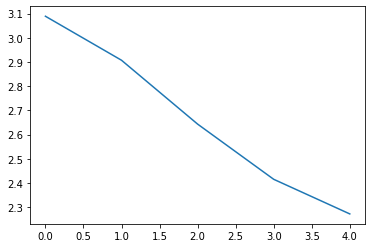

Epoch: 5 Batch: 0 WER: 1.34
Epoch: 5 Batch: 50 WER: 1.53
Epoch: 5 WER: 1.46


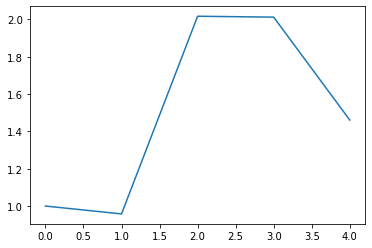

Epoch: 6 Batch: 0 Loss: 1.9357
Epoch: 6 Batch: 50 Loss: 2.4879
Epoch: 6 Batch: 100 Loss: 2.2692
Epoch: 6 Batch: 150 Loss: 2.1498
Epoch: 6 Batch: 200 Loss: 1.8407
Epoch: 6 Loss: 2.144303
Time taken for 1 epoch 346.73 sec



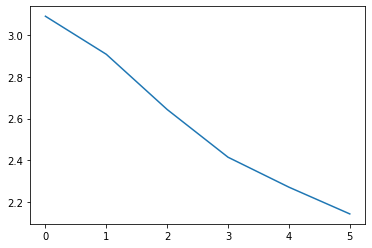

Epoch: 6 Batch: 0 WER: 0.88
Epoch: 6 Batch: 50 WER: 0.97
Epoch: 6 WER: 0.94


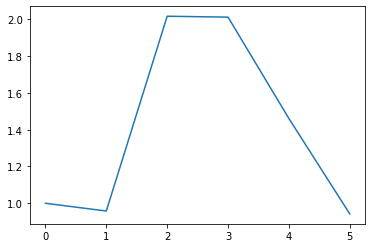

Epoch: 7 Batch: 0 Loss: 2.0347
Epoch: 7 Batch: 50 Loss: 2.0186
Epoch: 7 Batch: 100 Loss: 2.0387
Epoch: 7 Batch: 150 Loss: 1.7567
Epoch: 7 Batch: 200 Loss: 1.9412
Epoch: 7 Loss: 2.045336
Time taken for 1 epoch 346.67 sec



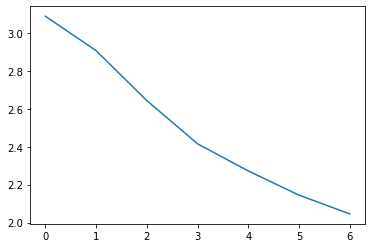

Epoch: 7 Batch: 0 WER: 0.89
Epoch: 7 Batch: 50 WER: 1.01
Epoch: 7 WER: 0.97


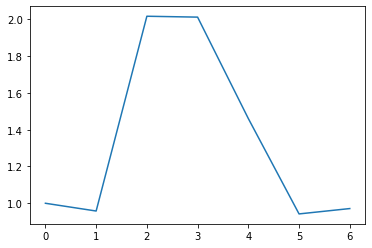

Epoch: 8 Batch: 0 Loss: 1.8840
Epoch: 8 Batch: 50 Loss: 2.1043
Epoch: 8 Batch: 100 Loss: 2.0693
Epoch: 8 Batch: 150 Loss: 1.9739
Epoch: 8 Batch: 200 Loss: 1.7417
Epoch: 8 Loss: 1.954841
Time taken for 1 epoch 346.72 sec



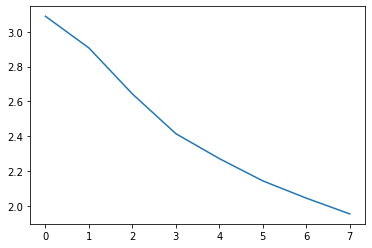

Epoch: 8 Batch: 0 WER: 1.10
Epoch: 8 Batch: 50 WER: 1.34
Epoch: 8 WER: 1.09


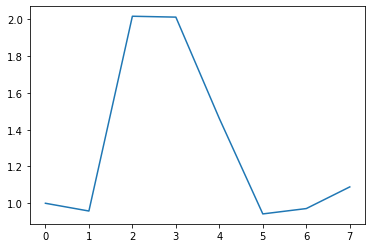

Epoch: 9 Batch: 0 Loss: 2.1142
Epoch: 9 Batch: 50 Loss: 1.8657
Epoch: 9 Batch: 100 Loss: 2.0442
Epoch: 9 Batch: 150 Loss: 2.1109
Epoch: 9 Batch: 200 Loss: 1.7039
Epoch: 9 Loss: 1.878496
Time taken for 1 epoch 346.13 sec



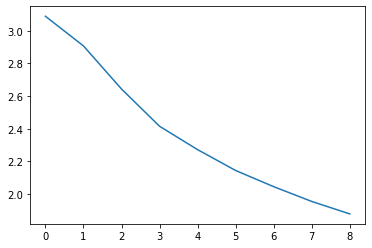

Epoch: 9 Batch: 0 WER: 1.56
Epoch: 9 Batch: 50 WER: 1.73
Epoch: 9 WER: 1.67


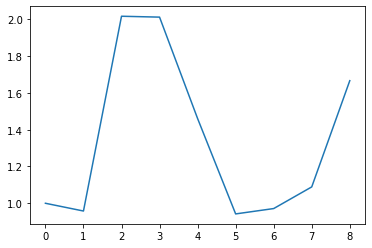

Epoch: 10 Batch: 0 Loss: 1.7953
Epoch: 10 Batch: 50 Loss: 1.6730
Epoch: 10 Batch: 100 Loss: 1.8127
Epoch: 10 Batch: 150 Loss: 1.5707
Epoch: 10 Batch: 200 Loss: 1.9449
Epoch: 10 Loss: 1.809460
Time taken for 1 epoch 346.56 sec



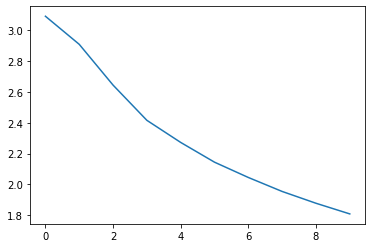

Epoch: 10 Batch: 0 WER: 1.54
Epoch: 10 Batch: 50 WER: 1.68
Epoch: 10 WER: 1.59


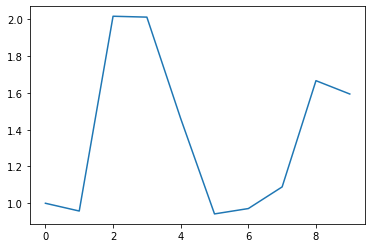

Epoch: 11 Batch: 0 Loss: 1.8230
Epoch: 11 Batch: 50 Loss: 1.6674
Epoch: 11 Batch: 100 Loss: 1.7446
Epoch: 11 Batch: 150 Loss: 1.7709
Epoch: 11 Batch: 200 Loss: 1.6634
Epoch: 11 Loss: 1.752156
Time taken for 1 epoch 346.55 sec



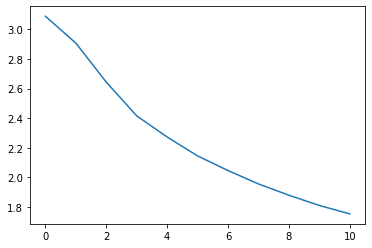

Epoch: 11 Batch: 0 WER: 1.65
Epoch: 11 Batch: 50 WER: 1.61
Epoch: 11 WER: 1.57


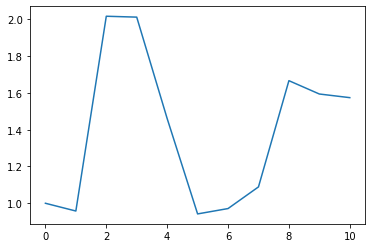

Epoch: 12 Batch: 0 Loss: 1.7553
Epoch: 12 Batch: 50 Loss: 1.6444
Epoch: 12 Batch: 100 Loss: 1.4429
Epoch: 12 Batch: 150 Loss: 1.9486
Epoch: 12 Batch: 200 Loss: 1.6048
Epoch: 12 Loss: 1.684498
Time taken for 1 epoch 346.39 sec



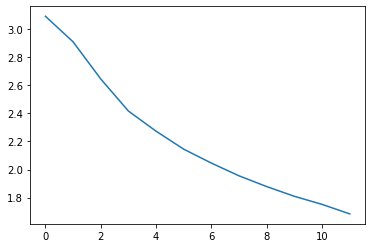

Epoch: 12 Batch: 0 WER: 1.63
Epoch: 12 Batch: 50 WER: 1.33
Epoch: 12 WER: 1.55


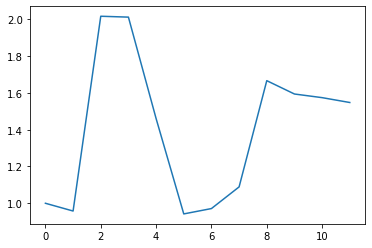

Epoch: 13 Batch: 0 Loss: 1.8251
Epoch: 13 Batch: 50 Loss: 1.5309
Epoch: 13 Batch: 100 Loss: 1.5704
Epoch: 13 Batch: 150 Loss: 1.3854
Epoch: 13 Batch: 200 Loss: 1.5381
Epoch: 13 Loss: 1.627556
Time taken for 1 epoch 347.99 sec



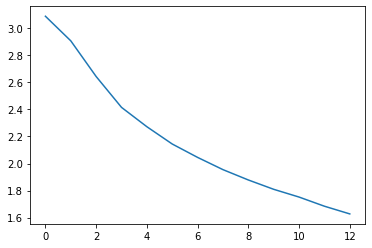

Epoch: 13 Batch: 0 WER: 0.87
Epoch: 13 Batch: 50 WER: 0.92
Epoch: 13 WER: 0.96


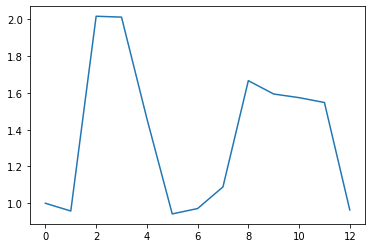

Epoch: 14 Batch: 0 Loss: 1.6274
Epoch: 14 Batch: 50 Loss: 1.5862
Epoch: 14 Batch: 100 Loss: 1.8591
Epoch: 14 Batch: 150 Loss: 1.9024
Epoch: 14 Batch: 200 Loss: 1.3190
Epoch: 14 Loss: 1.591702
Time taken for 1 epoch 346.59 sec



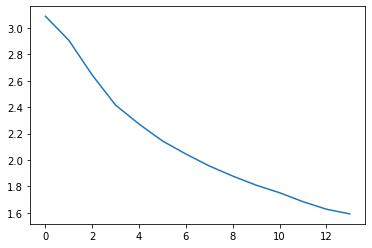

Epoch: 14 Batch: 0 WER: 0.82
Epoch: 14 Batch: 50 WER: 0.92
Epoch: 14 WER: 0.94


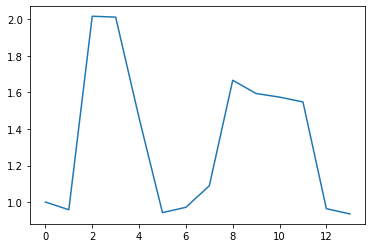

Epoch: 15 Batch: 0 Loss: 1.6068
Epoch: 15 Batch: 50 Loss: 1.6618
Epoch: 15 Batch: 100 Loss: 1.4625
Epoch: 15 Batch: 150 Loss: 1.3506
Epoch: 15 Batch: 200 Loss: 1.5240
Epoch: 15 Loss: 1.529305
Time taken for 1 epoch 346.01 sec



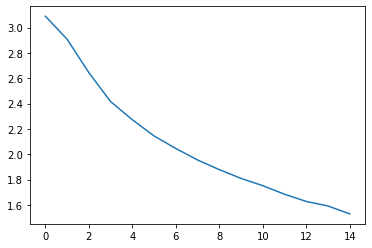

Epoch: 15 Batch: 0 WER: 0.85
Epoch: 15 Batch: 50 WER: 0.87
Epoch: 15 WER: 0.91


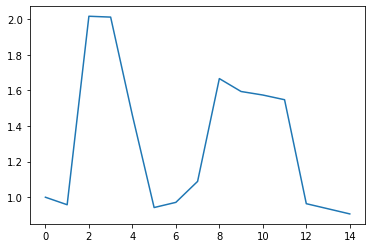

Epoch: 16 Batch: 0 Loss: 1.3691
Epoch: 16 Batch: 50 Loss: 1.5948
Epoch: 16 Batch: 100 Loss: 1.6490
Epoch: 16 Batch: 150 Loss: 1.4148
Epoch: 16 Batch: 200 Loss: 1.3040
Epoch: 16 Loss: 1.502939
Time taken for 1 epoch 345.75 sec



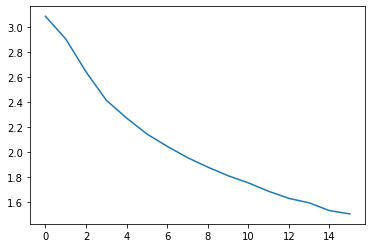

Epoch: 16 Batch: 0 WER: 1.00
Epoch: 16 Batch: 50 WER: 1.03
Epoch: 16 WER: 1.06


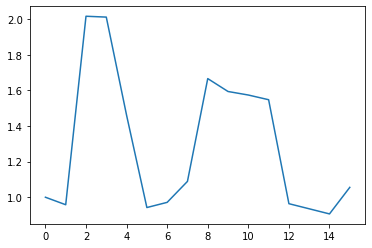

Epoch: 17 Batch: 0 Loss: 1.4839
Epoch: 17 Batch: 50 Loss: 1.4281
Epoch: 17 Batch: 100 Loss: 1.3669
Epoch: 17 Batch: 150 Loss: 1.5813
Epoch: 17 Batch: 200 Loss: 1.5743
Epoch: 17 Loss: 1.447898
Time taken for 1 epoch 346.13 sec



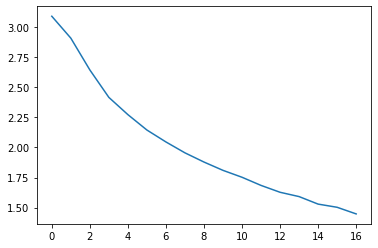

Epoch: 17 Batch: 0 WER: 1.09
Epoch: 17 Batch: 50 WER: 1.09
Epoch: 17 WER: 1.03


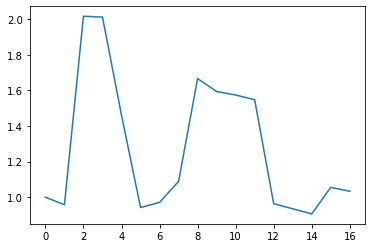

Epoch: 18 Batch: 0 Loss: 1.4201
Epoch: 18 Batch: 50 Loss: 1.3554
Epoch: 18 Batch: 100 Loss: 1.5042
Epoch: 18 Batch: 150 Loss: 1.5026
Epoch: 18 Batch: 200 Loss: 1.2401
Epoch: 18 Loss: 1.408260
Time taken for 1 epoch 345.55 sec



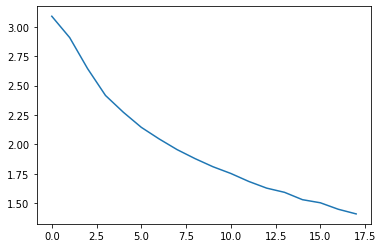

Epoch: 18 Batch: 0 WER: 0.87
Epoch: 18 Batch: 50 WER: 0.95
Epoch: 18 WER: 0.95


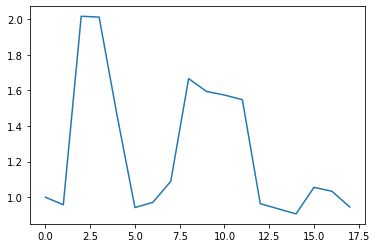

Epoch: 19 Batch: 0 Loss: 1.2324
Epoch: 19 Batch: 50 Loss: 1.3386
Epoch: 19 Batch: 100 Loss: 1.3688
Epoch: 19 Batch: 150 Loss: 1.3885
Epoch: 19 Batch: 200 Loss: 1.3302
Epoch: 19 Loss: 1.372635
Time taken for 1 epoch 347.69 sec



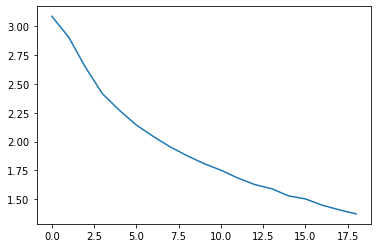

Epoch: 19 Batch: 0 WER: 0.87
Epoch: 19 Batch: 50 WER: 0.91
Epoch: 19 WER: 0.85


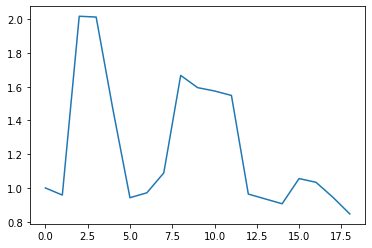

Epoch: 20 Batch: 0 Loss: 1.7148
Epoch: 20 Batch: 50 Loss: 1.1823
Epoch: 20 Batch: 100 Loss: 1.3380


KeyboardInterrupt: ignored

In [21]:
import time

epochs = 24

for epoch in range(start_epoch, epochs):
    start = time.time()
    total_loss = 0

    for batch, (images, targets) in enumerate(train_ds):

        batch_loss, t_loss = train_step(images, targets)
        total_loss += t_loss

        if batch % 50 == 0:
            average_batch_loss = batch_loss.numpy() / int(targets.shape[1])
            print(f'Epoch: {epoch + 1} Batch: {batch} Loss: {average_batch_loss:.4f}')

    loss_plot.append(total_loss / train_ds.cardinality().numpy())

    print(f'Epoch: {epoch + 1} Loss: {total_loss/train_ds.cardinality().numpy():.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

    plt.plot(loss_plot)
    plt.show()

    total_wer = 0
    for batch, (images, targets) in enumerate(test_ds):
        batch_wer = evaluate(images, targets)
        total_wer += batch_wer

        if batch % 50 == 0:
            print(f'Epoch: {epoch + 1} Batch: {batch} WER: {batch_wer:.2f}')
    
    wer_plot.append(total_wer / test_ds.cardinality().numpy())

    print(f'Epoch: {epoch + 1} WER: {total_wer/test_ds.cardinality().numpy():.2f}')

    plt.plot(wer_plot)
    plt.show()
    

    if epoch % 5 == 0:
        ckpt_manager.save()

Epoch: 21 Batch: 0 Loss: 1.0606
Epoch: 21 Batch: 50 Loss: 1.0540
Epoch: 21 Batch: 100 Loss: 0.8020
Epoch: 21 Batch: 150 Loss: 0.9203
Epoch: 21 Batch: 200 Loss: 0.6653
Epoch: 21 Batch: 250 Loss: 0.8828
Epoch: 21 Batch: 300 Loss: 1.1042
Epoch: 21 Batch: 350 Loss: 0.9456
Epoch: 21 Batch: 400 Loss: 0.7027
Epoch: 21 Batch: 450 Loss: 0.9426
Epoch: 21 Loss: 1.023838
Time taken for 1 epoch 327.55 sec



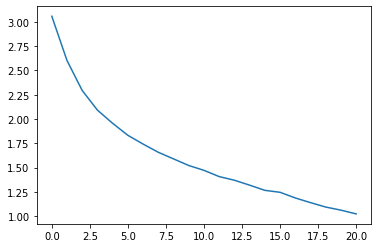

Epoch: 21 Batch: 0 WER: 1.09
Epoch: 21 Batch: 50 WER: 0.83
Epoch: 21 Batch: 100 WER: 1.22
Epoch: 21 WER: 0.99


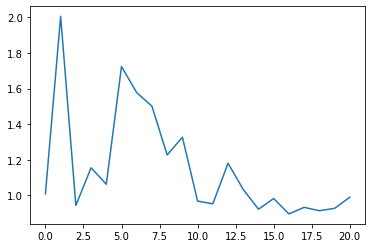

Epoch: 22 Batch: 0 Loss: 1.1604
Epoch: 22 Batch: 50 Loss: 0.9769
Epoch: 22 Batch: 100 Loss: 1.3502
Epoch: 22 Batch: 150 Loss: 0.9501
Epoch: 22 Batch: 200 Loss: 1.3283
Epoch: 22 Batch: 250 Loss: 1.0268
Epoch: 22 Batch: 300 Loss: 1.0584
Epoch: 22 Batch: 350 Loss: 1.1801
Epoch: 22 Batch: 400 Loss: 1.0144
Epoch: 22 Batch: 450 Loss: 0.6325
Epoch: 22 Loss: 1.078235
Time taken for 1 epoch 327.24 sec



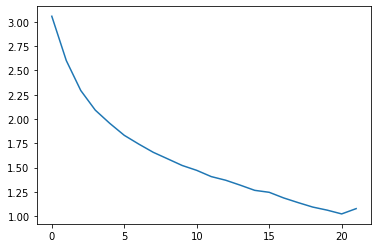

Epoch: 22 Batch: 0 WER: 0.81
Epoch: 22 Batch: 50 WER: 0.88
Epoch: 22 Batch: 100 WER: 0.91
Epoch: 22 WER: 0.91


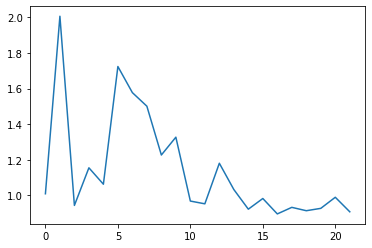

Epoch: 23 Batch: 0 Loss: 1.0708
Epoch: 23 Batch: 50 Loss: 0.9195
Epoch: 23 Batch: 100 Loss: 0.8010
Epoch: 23 Batch: 150 Loss: 0.8902
Epoch: 23 Batch: 200 Loss: 1.0541
Epoch: 23 Batch: 250 Loss: 0.7814
Epoch: 23 Batch: 300 Loss: 1.1707
Epoch: 23 Batch: 350 Loss: 1.0013
Epoch: 23 Batch: 400 Loss: 0.9772
Epoch: 23 Batch: 450 Loss: 1.2047
Epoch: 23 Loss: 0.941031
Time taken for 1 epoch 327.09 sec



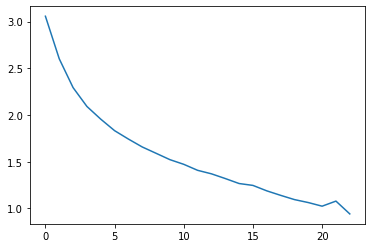

Epoch: 23 Batch: 0 WER: 1.09
Epoch: 23 Batch: 50 WER: 0.88
Epoch: 23 Batch: 100 WER: 0.98
Epoch: 23 WER: 0.93


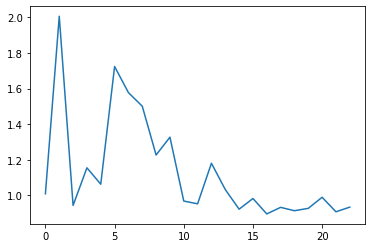

Epoch: 24 Batch: 0 Loss: 0.9645
Epoch: 24 Batch: 50 Loss: 1.1108
Epoch: 24 Batch: 100 Loss: 0.9318
Epoch: 24 Batch: 150 Loss: 1.0150
Epoch: 24 Batch: 200 Loss: 0.8347
Epoch: 24 Batch: 250 Loss: 1.0247
Epoch: 24 Batch: 300 Loss: 1.0295
Epoch: 24 Batch: 350 Loss: 0.6550
Epoch: 24 Batch: 400 Loss: 0.9536
Epoch: 24 Batch: 450 Loss: 1.0471
Epoch: 24 Loss: 0.897083
Time taken for 1 epoch 327.96 sec



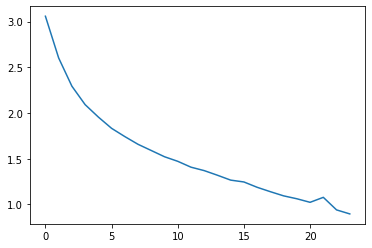

Epoch: 24 Batch: 0 WER: 1.15


In [ ]:
import time

epochs = 60

for epoch in range(20, epochs):
    start = time.time()
    total_loss = 0

    for batch, (images, targets) in enumerate(train_ds):

        batch_loss, t_loss = train_step(images, targets)
        total_loss += t_loss

        if batch % 50 == 0:
            average_batch_loss = batch_loss.numpy() / int(targets.shape[1])
            print(f'Epoch: {epoch + 1} Batch: {batch} Loss: {average_batch_loss:.4f}')

    loss_plot.append(total_loss / train_ds.cardinality().numpy())

    print(f'Epoch: {epoch + 1} Loss: {total_loss/train_ds.cardinality().numpy():.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

    plt.plot(loss_plot)
    plt.show()

    total_wer = 0
    for batch, (images, targets) in enumerate(test_ds):
        batch_wer = evaluate(images, targets)
        total_wer += batch_wer

        if batch % 50 == 0:
            print(f'Epoch: {epoch + 1} Batch: {batch} WER: {batch_wer:.2f}')
    
    wer_plot.append(total_wer / test_ds.cardinality().numpy())

    print(f'Epoch: {epoch + 1} WER: {total_wer/test_ds.cardinality().numpy():.2f}')

    plt.plot(wer_plot)
    plt.show()
    

    if epoch % 5 == 0:
        ckpt_manager.save()

 A WER of 5-10% is considered to be good quality and is ready to use. A WER of 20% is acceptable, but you might want to consider additional training. A WER of 30% or more signals poor quality and requires customization and training.

## Save model

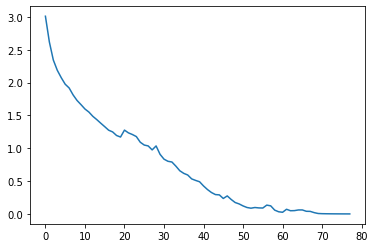

In [ ]:
plt.plot(loss_plot)

In [24]:
# save checkpoint
!tar -czf drive/MyDrive/checkpoint/htr/checkpoints2.tar.gz ./checkpoints

In [25]:
with open('drive/MyDrive/checkpoint/htr/loss_plot2.pkl', 'wb') as f:
    pickle.dump(loss_plot, f)

with open('drive/MyDrive/checkpoint/htr/wer_plot2.pkl', 'wb') as f:
    pickle.dump(wer_plot, f)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract checkpoint archive
!tar -xf drive/MyDrive/checkpoint/htr/checkpoints.tar.gz -C ./

In [ ]:
# load checkpoint
ckpt_path = tf.train.latest_checkpoint(checkpoint_path)
ckpt.restore(ckpt_path)

In [ ]:
with open('drive/MyDrive/checkpoint/htr/loss_plot.pkl', 'rb') as f:
    loss_plot = pickle.load(f)

with open('drive/MyDrive/checkpoint/htr/wer_plot.pkl', 'wb') as f:
    pickle.dump(wer_plot, f)

In [ ]:
for images, targets in train_ds:
    for image, target in zip(images, targets):
        # plt.figure(figsize=(15, 3))
        # plt.imshow(1 - image)
        # plt.show()
        result, attention_plot = evaluate(image)
        print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
        print('Pred:', ' '.join(result))
    break

True: <start> Số 459 phố Kim Ngưu Phường Vĩnh Tuy Quận Hai Bà Trưng Hà Nội <end>
Pred: Số 459 phố Kim Ngưu Phường Vĩnh Tuy Quận Hai Bà Trưng Hà Nội <end>
True: <start> Km 948600 Quốc lộ 1A Xã Điện Thắng Bắc Huyện Điện Bàn Quảng Nam <end>
Pred: Km 948600 Quốc lộ 5A Xã Bạch Thắng Huyện Long Thành Quảng Nam <end>
True: <start> Khu 7 Thị Trấn ái Nghĩa Huyện Đại Lộc Quảng Nam <end>
Pred: Khu 7 Thị Trấn ái Nghĩa Huyện Đại Lộc Quảng Nam <end>
True: <start> Số 117 Hùng Vương Phường Sở Dầu Quận Hồng Bàng Hải Phòng <end>
Pred: Số 117 Hùng Vương Phường Sở Nghé Quận Hà Đông Hà Nội <end>


In [ ]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(60, 12))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (3, 59))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(1 - image / tf.reduce_max(image))
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


In [ ]:
for images, targets in train_ds:
    for image, target in zip(images, targets):
        result, attention_plot = evaluate(image)
        plot_attention(image, result, attention_plot)
        print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
        print('Pred:', ' '.join(result))
    break

0.7592592592592593


In [ ]:
print(true_texts)
print(pred_texts)

['Số 10 đường Lý Văn Lâm Phường 1 Thành Phố Cà Mau Cà Mau', '271 Huỳnh Ngọc Huệ Phường Hoà Khê Quận Thanh Khê Đà Nẵng', 'Số [UNK] KP 9 Phường Hố Nai Thành Phố Biên Hoà Đồng Nai', 'Số [UNK] tổ 8 ấp Tân Hòa Xã Tân Tiến Huyện Bù Đốp Bình Phước']
['Số nhà 71 phố 4 Phường Tân Tiến Thành phố Đồng Hới Quảng Trị', '729 âu Cơ Phường Thanh Khê Đông Quận Thanh Khê Đà Nẵng', 'Số 79 tổ 23 Phường Khương Đình Quận Cầu Giấy Hà Nội', 'Số 79 ngõ 328 Lê Lợi Xã Diên Khánh Huyện Diên Khánh Hà Nội']


In [ ]:
for image, target in zip(images, targets):
    result, attention_plot = evaluate(image)
    print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
    print('Pred:', ' '.join(result))

True: <start> Khu 3 Xã Cát Quế Huyện Hoài Đức Hà Nội <end>
Pred: Khu 3 Xã Cát Quế Huyện Hoài Đức Hà Nội <end>
True: <start> Số 79 Đường số 37 Khu phố 2 Phường 10 Quận 6 TP Hồ Chí Minh <end>
Pred: Số 79 Đường số 37 Khu phố 2 Phường 10 Quận 6 TP Hồ Chí Minh <end>
True: <start> Số 25 Nguyễn Bỉnh Khiêm Phường 8 Thành phố Cà Mau Cà Mau <end>
Pred: Số 25 Nguyễn Bỉnh Khiêm Phường 8 Thành phố Cà Mau Cà Mau <end>
True: <start> 271/7B An Dương Vương Phường 03 Quận 5 TP Hồ Chí Minh <end>
Pred: 271/7B An Dương Vương Phường 03 Quận 5 TP Hồ Chí Minh <end>


https://www.tensorflow.org/tutorials/text/image_captioning

https://www.tensorflow.org/text/tutorials/nmt_with_attention

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_captioning.ipynb#scrollTo=StQK3dgDcri0

https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

https://keras.io/examples/nlp/semantic_similarity_with_bert/


## References
1. https://arxiv.org/pdf/1703.09137.pdf
2. https://viblo.asia/p/a-guide-to-image-captioning-part-1-gioi-thieu-bai-toan-sinh-mo-ta-cho-anh-gAm5yr88Kdb
3. https://www.tensorflow.org/tutorials/text/image_captioning
4. https://arxiv.org/pdf/1502.03044.pdf
5. https://keras.io/examples/vision/image_captioning/
6. https://machinelearningmastery.com/the-bahdanau-attention-mechanism/
7. https://keras.io/examples/audio/ctc_asr/